# Data Loading

Reading the data from the files.

In [1]:
import numpy as np

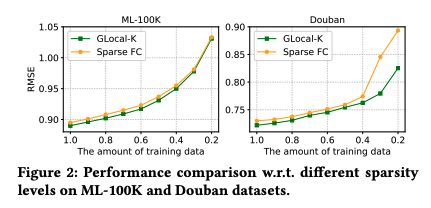

In [2]:
train = np.loadtxt('./movielens_100k_u1.base', skiprows=0, delimiter='\t')
test = np.loadtxt('./movielens_100k_u1.test', skiprows=0, delimiter='\t')

In [3]:
train[:5]

array([[1.00000000e+00, 1.00000000e+00, 5.00000000e+00, 8.74965758e+08],
       [1.00000000e+00, 2.00000000e+00, 3.00000000e+00, 8.76893171e+08],
       [1.00000000e+00, 3.00000000e+00, 4.00000000e+00, 8.78542960e+08],
       [1.00000000e+00, 4.00000000e+00, 3.00000000e+00, 8.76893119e+08],
       [1.00000000e+00, 5.00000000e+00, 3.00000000e+00, 8.89751712e+08]])

In [4]:
train = train.astype('int')
test = test.astype('int')
train[:5]

array([[        1,         1,         5, 874965758],
       [        1,         2,         3, 876893171],
       [        1,         3,         4, 878542960],
       [        1,         4,         3, 876893119],
       [        1,         5,         3, 889751712]])

In [5]:
print(train.shape, test.shape)

n_train_ratings = len(train)
n_test_ratings = len(test)

(80000, 4) (20000, 4)


In [6]:
all_data = np.concatenate((train, test), axis=0)

n_user = np.unique(all_data[:,0]).size
n_movies = np.unique(all_data[:,1]).size

print(n_user, n_movies)

943 1682


In [7]:
train_ratings_matrix = np.zeros((n_movies, n_user), dtype='float')
test_ratings_matrix = np.zeros((n_movies, n_user), dtype='float')
print(train_ratings_matrix.shape, test_ratings_matrix.shape)

for i in range(n_train_ratings):
    train_ratings_matrix[train[i,1]-1, train[i,0]-1] = train[i,2]

for i in range(n_test_ratings):
    test_ratings_matrix[test[i,1]-1, test[i,0]-1] = test[i,2]

print(train_ratings_matrix[:5, :5], test_ratings_matrix[:5, :5])

(1682, 943) (1682, 943)
[[5. 4. 0. 0. 0.]
 [3. 0. 0. 0. 0.]
 [4. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0.]
 [3. 0. 0. 0. 0.]] [[0. 0. 0. 0. 4.]
 [0. 0. 0. 0. 3.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [8]:
train_read_matrix = np.greater(train_ratings_matrix, 1e-12).astype('float')
test_read_matrix = np.greater(test_ratings_matrix, 1e-12).astype('float')

print(train_read_matrix[:5, :5], test_read_matrix[:5, :5])

[[1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]] [[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


# GLocal - K

After reading the paper, we get the following hyperparameters.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
# Hyperparamters from the paper
n_hid = 500
n_dim = 5
n_layers = 2
gk_size = 3
max_epoch_p = 500
max_epoch_f = 1000
patience_p = 5
patience_f = 10
tol_p = 1e-4
tol_f = 1e-5
lambda_2 = 20.
lambda_s = 0.006
dot_scale = 1

## Kernel Network Definition

In [11]:
def compute_local_kernel(u, v):
    distance = torch.norm(u - v, p=2, dim=2)
    clamped_value = torch.clamp(1. - distance**2, min=0.)
    return clamped_value


In [12]:
class CustomKernelLayer(nn.Module):
    def __init__(self, input_size, hidden_size, feature_dim, sparse_reg_lambda, l2_reg_lambda, activation_function=nn.Sigmoid()):
        super().__init__()
        self.weight_matrix = nn.Parameter(torch.randn(input_size, hidden_size))
        self.vector_u = nn.Parameter(torch.randn(input_size, 1, feature_dim))
        self.vector_v = nn.Parameter(torch.randn(1, hidden_size, feature_dim))
        self.bias = nn.Parameter(torch.randn(hidden_size))

        self.sparse_reg_lambda = sparse_reg_lambda
        self.l2_reg_lambda = l2_reg_lambda

        nn.init.xavier_uniform_(self.weight_matrix, gain=nn.init.calculate_gain("relu"))
        nn.init.xavier_uniform_(self.vector_u, gain=nn.init.calculate_gain("relu"))
        nn.init.xavier_uniform_(self.vector_v, gain=nn.init.calculate_gain("relu"))
        nn.init.zeros_(self.bias)

        self.activation_function = activation_function

    def forward(self, input_data):
        weight_kernel = compute_local_kernel(self.vector_u, self.vector_v)

        sparse_loss = F.mse_loss(weight_kernel, torch.zeros_like(weight_kernel))
        sparse_loss_term = self.sparse_reg_lambda * sparse_loss

        l2_loss = F.mse_loss(self.weight_matrix, torch.zeros_like(self.weight_matrix))
        l2_loss_term = self.l2_reg_lambda * l2_loss

        effective_weights = self.weight_matrix * weight_kernel
        output = torch.matmul(input_data, effective_weights) + self.bias
        output = self.activation_function(output)

        return output, sparse_loss_term + l2_loss_term

In [13]:
class KernelNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, feature_dim, num_layers, sparse_reg_lambda, l2_reg_lambda):
        super().__init__()
        layers = []
        for layer_index in range(num_layers):
            if layer_index == 0:
                layers.append(CustomKernelLayer(input_size, hidden_size, feature_dim, sparse_reg_lambda, l2_reg_lambda))
            else:
                layers.append(CustomKernelLayer(hidden_size, hidden_size, feature_dim, sparse_reg_lambda, l2_reg_lambda))
        layers.append(CustomKernelLayer(hidden_size, input_size, feature_dim, sparse_reg_lambda, l2_reg_lambda, activation_function=nn.Identity()))

        self.layers = nn.ModuleList(layers)
        self.dropout_layer = nn.Dropout(0.33)

    def forward(self, input_data):
        total_regularization = None
        for layer_index, layer in enumerate(self.layers):
            input_data, regularization_term = layer(input_data)
            if layer_index < len(self.layers) - 1:
                input_data = self.dropout_layer(input_data)

            if total_regularization is None:
                total_regularization = regularization_term
            else:
                total_regularization += regularization_term
        return input_data, total_regularization


In [14]:
model = KernelNetwork(
    input_size=n_user,
    hidden_size=n_hid,
    feature_dim=n_dim,
    num_layers=n_layers,
    sparse_reg_lambda=lambda_s,
    l2_reg_lambda=lambda_2
).double().to(device)

## Complete Model Definition

In [15]:
class CompleteModel(nn.Module):
    def __init__(self, kernel_network, input_size, output_size, hidden_size, feature_dim, num_layers, sparse_reg_lambda, l2_reg_lambda, kernel_size, scaling_factor):
        super().__init__()
        self.kernel_size = kernel_size
        self.scaling_factor = scaling_factor
        self.kernel_network = kernel_network
        self.conv_kernel = nn.Parameter(torch.randn(output_size, kernel_size**2) * 0.1)
        nn.init.xavier_uniform_(self.conv_kernel, gain=nn.init.calculate_gain("relu"))

    def forward(self, input_data, local_data):
        global_kernel = self.compute_global_kernel(local_data, self.kernel_size, self.scaling_factor)
        input_data = self.apply_global_convolution(input_data, global_kernel)
        input_data, reg_loss = self.kernel_network(input_data)
        return input_data, reg_loss

    def compute_global_kernel(self, input_data, kernel_size, scaling_factor):
        avg_pool = torch.mean(input_data, dim=1)
        avg_pool = avg_pool.view(1, -1)

        global_kernel = torch.matmul(avg_pool, self.conv_kernel) * scaling_factor
        global_kernel = global_kernel.view(1, 1, kernel_size, kernel_size)

        return global_kernel

    def apply_global_convolution(self, input_data, kernel):
        input_data = input_data.unsqueeze(0).unsqueeze(0)
        conv_output = nn.LeakyReLU()(F.conv2d(input_data, kernel, stride=1, padding=1))
        return conv_output.squeeze(0).squeeze(0)

In [16]:
class CustomLoss(nn.Module):
    def forward(self, predicted_values, regularization_loss, ground_truth_mask, ground_truth_values):
        error_diff = ground_truth_mask * (ground_truth_values - predicted_values)
        squared_error = F.mse_loss(error_diff, torch.zeros_like(error_diff))
        total_loss = squared_error + regularization_loss
        return total_loss


In [17]:
complete_model = CompleteModel(
    kernel_network=model,
    input_size=n_user,
    output_size=n_movies,
    hidden_size=n_hid,
    feature_dim=n_dim,
    num_layers=n_layers,
    sparse_reg_lambda=lambda_s,
    l2_reg_lambda=lambda_2,
    kernel_size=gk_size,
    scaling_factor=dot_scale
).double().to(device)

In [18]:
best_rmse_epoch= 0
best_rmse_value = float("inf")

prev_epoch_rmse = np.inf
early_stop_counter = 0

# Pre-Training Step

In [19]:
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.parameter import Parameter

In [20]:
optimizer = torch.optim.AdamW(complete_model.kernel_network.parameters(), lr=0.001)

def optimization_step():
    optimizer.zero_grad()
    x_data = torch.Tensor(train_ratings_matrix).double().to(device)
    m_data = torch.Tensor(train_read_matrix).double().to(device)
    complete_model.kernel_network.train()
    predictions, regularization = complete_model.kernel_network(x_data)
    loss_value = CustomLoss().to(device)(predictions, regularization, m_data, x_data)
    loss_value.backward()
    return loss_value

In [21]:
for epoch in range(max_epoch_p):
    optimizer.step(optimization_step)
    complete_model.kernel_network.eval()

    predictions, _ = model(torch.Tensor(train_ratings_matrix).double().to(device))
    predictions = predictions.float().cpu().detach().numpy()

    test_error = (test_read_matrix * (np.clip(predictions, 1., 5.) - test_ratings_matrix) ** 2).sum() / test_read_matrix.sum()
    test_rmse_value = np.sqrt(test_error)

    train_error = (train_read_matrix * (np.clip(predictions, 1., 5.) - train_ratings_matrix) ** 2).sum() / train_read_matrix.sum()
    train_rmse_value = np.sqrt(train_error)

    if prev_epoch_rmse - train_rmse_value < tol_p:
        early_stop_counter += 1
    else:
        early_stop_counter = 0

    prev_epoch_rmse = train_rmse_value

    if patience_p == early_stop_counter:
        print('----' * 12)
        print('Final Pre-training Results')
        print(f'Epoch: {epoch+1}, Test RMSE: {test_rmse_value}, Train RMSE: {train_rmse_value}')
        print('----' * 12)
        break

    if (epoch + 1) % 5 == 0:
        print(f'Epoch: {epoch+1}, Test RMSE: {test_rmse_value}, Train RMSE: {train_rmse_value}')
        print('\n' * 2)

Epoch: 5, Test RMSE: 2.372223584825849, Train RMSE: 2.29001860075824



Epoch: 10, Test RMSE: 1.331196179516383, Train RMSE: 1.270786346688165



Epoch: 15, Test RMSE: 1.3500448042436821, Train RMSE: 1.335611359590924



Epoch: 20, Test RMSE: 1.1986050376046182, Train RMSE: 1.1619538043148137



Epoch: 25, Test RMSE: 1.1219000589999308, Train RMSE: 1.0897545631131518



Epoch: 30, Test RMSE: 1.1360954696174568, Train RMSE: 1.1035919699946035



Epoch: 35, Test RMSE: 1.0757220417234816, Train RMSE: 1.0372526424169979



Epoch: 40, Test RMSE: 1.0467675535379806, Train RMSE: 1.0088412803987448



Epoch: 45, Test RMSE: 1.0395826622775342, Train RMSE: 1.0010252260137262



Epoch: 50, Test RMSE: 1.0241035065386692, Train RMSE: 0.9836134463529624



Epoch: 55, Test RMSE: 1.0200814953376385, Train RMSE: 0.9804915494817497



Epoch: 60, Test RMSE: 0.9997325500769475, Train RMSE: 0.9594270117627264



Epoch: 65, Test RMSE: 0.986865262671257, Train RMSE: 0.9461706780261556



Epoch: 70, Test RMSE

# Fine Tuning Step

In [22]:
train_ratings_matrix_local = np.clip(predictions, 1., 5.)

optimizer = torch.optim.AdamW(complete_model.parameters(), lr=0.001)

previous_epoch_rmse = np.inf
early_stop_counter = 0

def optimization_step():
    optimizer.zero_grad()
    x_data = torch.Tensor(train_ratings_matrix).double().to(device)
    x_local_data = torch.Tensor(train_ratings_matrix_local).double().to(device)
    mask_data = torch.Tensor(train_read_matrix).double().to(device)
    complete_model.train()
    predicted_values, regularization = complete_model(x_data, x_local_data)
    loss_value = CustomLoss().to(device)(predicted_values, regularization, mask_data, x_data)
    loss_value.backward()
    return loss_value

In [23]:
for epoch in range(max_epoch_f):
    optimizer.step(optimization_step)
    complete_model.eval()

    predictions, _ = complete_model(torch.Tensor(train_ratings_matrix).double().to(device), torch.Tensor(train_ratings_matrix_local).double().to(device))

    predictions = predictions.float().cpu().detach().numpy()

    test_error = (test_read_matrix * (np.clip(predictions, 1., 5.) - test_ratings_matrix) ** 2).sum() / test_read_matrix.sum()
    test_rmse_value = np.sqrt(test_error)

    train_error = (train_read_matrix * (np.clip(predictions, 1., 5.) - train_ratings_matrix) ** 2).sum() / train_read_matrix.sum()
    train_rmse_value = np.sqrt(train_error)

    if test_rmse_value < best_rmse_value:
        best_rmse_value = test_rmse_value
        best_rmse_epoch = epoch + 1

    if previous_epoch_rmse - train_rmse_value < tol_f:
        early_stop_counter += 1
    else:
        early_stop_counter = 0

    previous_epoch_rmse = train_rmse_value

    if patience_f == early_stop_counter:
        print('----' * 12)
        print('Final Fine Tuning Results')
        print(f'Epoch: {epoch+1}, Test RMSE: {test_rmse_value}, Train RMSE: {train_rmse_value}')
        print('----' * 12)
        break

    if (epoch + 1) % 50 == 0:
        print(f'Epoch: {epoch+1}, Test RMSE: {test_rmse_value}, Train RMSE: {train_rmse_value}')
        print('\n' * 2)


Epoch: 50, Test RMSE: 0.9198803645858691, Train RMSE: 0.8539617611163596



Epoch: 100, Test RMSE: 0.9117336207185338, Train RMSE: 0.847897743699682



Epoch: 150, Test RMSE: 0.909903279522329, Train RMSE: 0.8465377859141278



Epoch: 200, Test RMSE: 0.908746190640718, Train RMSE: 0.8430350718498706



Epoch: 250, Test RMSE: 0.9078477303572166, Train RMSE: 0.8403767495312037



Epoch: 300, Test RMSE: 0.9093008251578296, Train RMSE: 0.8388935864429119



Epoch: 350, Test RMSE: 0.9080443606669836, Train RMSE: 0.838218061156242



Epoch: 400, Test RMSE: 0.9087939978406312, Train RMSE: 0.8371400365808922



Epoch: 450, Test RMSE: 0.9093375213170943, Train RMSE: 0.8365896947062822



Epoch: 500, Test RMSE: 0.9086859705545131, Train RMSE: 0.8362627683859649



Epoch: 550, Test RMSE: 0.9084404963423248, Train RMSE: 0.8349780158756004



Epoch: 600, Test RMSE: 0.908996001001929, Train RMSE: 0.8345963241049202



Epoch: 650, Test RMSE: 0.9088293903911062, Train RMSE: 0.8328797954488208



Epoch

In [24]:
best_rmse_epoch, best_rmse_value

(998, 0.9066639320630632)